# C Elegans Locomotion Simulations Platform

The purpose of this notebook is to allow a faster, easier and more user-friendly "tweak, tune, run, plot" loop for the discrete neurons Rhapsody project.

This notebook replaces the need to switch back and forth between excel (for parameters editing), Spyder (for python-script editing), Matlab (for plotting) and Rhapsody (for whatever reason). Instead, the idea is that **everything** can be done at one place.

## Table of Content

* [Importing & defining global variables](#Importing-&-defining-global-variables)
* [Creating the weights file](#Creating-the-weights-file)
* [Updating simulation parameter file](#Updating-simulation-parameter-file)
* [Running the simulation](#Running-the-simulation)
* [Plotting the results](#Plotting-the-results)

## Importing & defining global variables

We begin by importing the necessary python modules:

In [52]:
# Standard python modules we use for number-crunching and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Import statements for the interactive params changing part
from __future__ import print_function
from IPython.html.widgets import interact, interactive, fixed
#import IPython.html.widgets
from IPython.html import widgets

# home made .py file that contains the importing functions of all input params
import c_elegans_locomotion

We continue by telling the program where it can find the relevant files:

In [53]:
# This is the csv file in which every row is "neuron_name, neuron_number, neuron_type
GLOBAL_NAMESFILE = 'C:\Users\hlapid\Desktop\CSVFiles\\names.csv'

# This is the csv file with all the known chemical weights - our chemical "connectome":
GLOBAL_CHWEIGHTSFILE = 'C:\Users\hlapid\Desktop\CSVFiles\CHweights_normed.csv'
# This is the csv file with NMJ weights - the e-phys output:
GLOBAL_NMJWEIGHTSFILE = 'C:\Users\hlapid\Desktop\CSVFiles\NMJweights.csv'

# This is the csv file with the Rhapsody simulation parameters:
GLOBAL_PARAMSFILE = 'C:\Users\hlapid\Desktop\CSVFiles\params.csv'

# This is the log file that the rhapsody simulation creates.
# It doesn't need a full path because the notebook and the file are kept in the same directory.
GLOBAL_LOGFILE = 'dis_component_log.csv'

We proceed by defining the dictionary containing all the "protected" chemical weights - meaning, all the synapses with known polarity. This can be extended whenever we wish, and can also contain the source (from which we learned the polarity) as a comment.

The dictionary is a dictionary of dictionaries. Each key in "protectedDict" stands for a presynaptic neuron. Each value is a dictionary, corresponding to the appropriate postsynaptic neurons and the respective polarity.

In [54]:
protectedDict = {"ALML" : {"AVDL" : "+", "AVDR" : "+"},
                 "ALMR" : {"AVDR" : "+", "AVDL" : "+"},
                 "AVDL" : {"AVAL" : "+", "AVAR" : "+"},
                 "AVDR" : {"AVAL" : "+", "AVAR" : "+"},
                 "AVM" : {"AVBL" : "-", "AVBR" : "-"},
                 "RIML" : {"AVBL" : "-", "AVBR" : "-", "SMDDL" : "-", "SMDVL" : "-", "SMDDR" : "-", "SMDVR" : "-", },
                 "RIMR" : {"AVBL" : "-", "AVBR" : "-", "SMDDL" : "-", "SMDVL" : "-", "SMDDR" : "-", "SMDVR" : "-", },
                 "AIBL" : {"RIML" : "-", "RIMR" : "-", "SMDDL" : "-", "SMDVL" : "-", "SMDDR" : "-", "SMDVR" : "-", },
                 "AIBR" : {"RIML" : "-", "RIMR" : "-", "SMDDL" : "-", "SMDVL" : "-", "SMDDR" : "-", "SMDVR" : "-", }}

Next - create the names dictionary. We use a method from discreteNeurons. As a sanity check, it's easy to print the dataframe by adding:
>; namesDF 

to the following row:

In [55]:
namesDF = c_elegans_locomotion.createDict(GLOBAL_NAMESFILE)

We now turn to read the chemical weights dataframe. Again, we use a method from c_elegans_locomotion, and again, as a sanity check, it's easy to print the dataframe by adding:
>; chDF 

to the following row:

In [56]:
[chDF,nmjDF,muscleNamesDF] = c_elegans_locomotion.createMatrix(namesDF, GLOBAL_CHWEIGHTSFILE,GLOBAL_NMJWEIGHTSFILE)

## Creating the weights file

This is a very important part of the python script, and this is why I chose to add it here "as it is" instead of calling it from a function. This is the part in which we tell the program which polarity we want for every synapse:

In [57]:
# Create list of commands - each command is a tuple:
# (preSynaptic (=row in chMatrix), postSynaptic (=column in chMatrix), synapse sign)
# Exmaple: commandsList.append(('AVDL', 'all', '+'))
# Exmaple: commandsList.append(('AVDR', 'AVAL', '-'))
commandsList = []
for pre_name, pre_row in namesDF.iterrows():
    # presynaptic cell is interneuron
    if pre_row['type'] == "IN":
        for post_name, post_row in namesDF.iterrows():   
            if post_row['type'] == "IN":
                commandsList.append((pre_name, post_name, '-'))
            elif post_row['type'] == "SN":
                commandsList.append((pre_name, post_name, '+'))
            elif post_row['type'] == "MN":
                commandsList.append((pre_name, post_name, '+'))
    # presynaptic cell is sensory
    elif pre_row['type'] == "SN":
        for post_name, post_row in namesDF.iterrows():   
            if post_row['type'] == "IN":
                commandsList.append((pre_name, post_name, '+'))
            elif post_row['type'] == "SN":
                commandsList.append((pre_name, post_name, '+'))
            elif post_row['type'] == "MN":
                commandsList.append((pre_name, post_name, '+'))
    # presynaptic cell is motor
    elif pre_row['type'] == "MN":
        for post_name, post_row in namesDF.iterrows():   
            if post_row['type'] == "IN":
                commandsList.append((pre_name, post_name, '-'))
            elif post_row['type'] == "SN":
                commandsList.append((pre_name, post_name, '-'))
            elif post_row['type'] == "MN":
                commandsList.append((pre_name, post_name, '+'))

In [58]:
chDF2 = c_elegans_locomotion.applyCommands(chDF, commandsList, namesDF)

This code makes AVBL\R inhibitory to all VA/DA, and AVAL\R inhibitory to all VB/DB.

DA/VA/DB/VB excitatory to D class neurons
D class neurons inhibitory to all their post synaptic neurons:

In [59]:
for pre_name, pre_row in namesDF.iterrows():
    # presynaptic cell is interneuron
    if pre_name == "AVBL" or pre_name == "AVBR":
        for post_name, post_row in namesDF.iterrows():   
            if ("VA" in post_name or "DA" in post_name) and not ("AVA" in post_name):
                commandsList.append((pre_name, post_name, '-'))
    elif pre_name == "AVAL" or pre_name == "AVAR":
        for post_name, post_row in namesDF.iterrows():   
            if ("VB" in post_name or "DB" in post_name) and not ("AVB" in post_name):
                commandsList.append((pre_name, post_name, '-'))
#    elif ("VB" in pre_name) and not ("AVB" in pre_name):
#        for post_name, post_row in namesDF.iterrows():   
#            if ("DB" in post_name):
#                commandsList.append((pre_name, post_name, '-'))
#            elif ("DD" in post_name) and not ("SMDD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#            elif ("VD" in post_name) and not ("AVD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#    elif ("DB" in pre_name):
#        for post_name, post_row in namesDF.iterrows():   
#            if ("VB" in post_name) and not ("AVB" in post_name):
#                commandsList.append((pre_name, post_name, '-'))
#            elif ("DD" in post_name) and not ("SMDD" in post_name): 
#                commandsList.append((pre_name, post_name, '+'))
#            elif ("VD" in post_name) and not ("AVD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#    elif ("VA" in pre_name) and not ("AVA" in pre_name):
#        for post_name, post_row in namesDF.iterrows():   
#            if ("DA" in post_name):
#                commandsList.append((pre_name, post_name, '-'))
#            elif ("DD" in post_name) and not ("SMDD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#            elif ("VD" in post_name) and not ("AVD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#    elif ("DA" in pre_name):
#        for post_name, post_row in namesDF.iterrows():   
#            if ("VA" in post_name) and not ("AVA" in post_name):
#                commandsList.append((pre_name, post_name, '-'))
#            elif ("DD" in post_name) and not ("SMDD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))
#            elif ("VD" in post_name) and not ("AVD" in post_name):
#                commandsList.append((pre_name, post_name, '+'))

    # presynaptic cell is D class neuron inhibits MNs
    elif ("DD" in pre_name) and not ("SMDD" in pre_name):
#      for post_name, post_row in namesDF.iterrows():   
         #   if post_row['type'] == "MN":
        #  commandsList.append((pre_name, post_name, '-'))
        commandsList.append((pre_name,"all","-"))
    elif ("VD" in pre_name) and not ("AVD" in pre_name):
#        for post_name, post_row in namesDF.iterrows():   
#            if post_row['type'] == "MN":
#                commandsList.append((pre_name, post_name, '-'))         
        commandsList.append((pre_name,"all","-"))
# commandsList.append(("all","AVDL","-"))

We now apply all these commands to the chemical weights dataframe: 

In [60]:
chDF2 = c_elegans_locomotion.applyCommands(chDF, commandsList, namesDF)

And overwrite the dataframe according to the protectedDict polarities:

In [61]:
protectedDF = c_elegans_locomotion.applyProtected(chDF2, protectedDict)

Lastly, we finish by saving this weights file back to the original weights file:

In [62]:
protectedDF.to_csv(GLOBAL_CHWEIGHTSFILE, header=False, index=False) 

Just a check - this value should be positive, regardless of the weights declared above, since it's a "protected" value:

## Updating simulation parameter file

The Rhapsody simulation reads its parameters (such as neuron decay time, simulation runtime, synaptic strength coefficients, etc) from a CSV file. This path for this file was defined when we defined all global variables above.

The parameter CSV file can be easily imported into a dataframe:

In [63]:
paramsDF = pd.read_csv(GLOBAL_PARAMSFILE, header=None, index_col=0, names = ['value', 'description'])

We define this simple function for changing the parameters and their default values:

In [64]:
paramsDF = c_elegans_locomotion.changeParams(paramsDF, EJCoeff=.1, CHCoeff=5, NMJCoeff=1, simRuntime=2000, decayTime=.2,    
                        propCoeff=3, LeakyCoeff=0.999 ,EJSynDelay=1, CHSynDelay=5, NMJSynDelay=1, SignalAttenuation=0.999,
                        delta_t = 0.001)

And now we use a simple JavaScript widget to easily tune these:

In [65]:
print(paramsDF)
#interact(changeParams, EJCoeff=(0.0,1.5,0.01), CHCoeff=(0.0,10,0.1), simRuntime=(100,1000),
#       decayTime=(1,100), propCoeff=(1.0,50.0), LeakyCoeff=(0.0,1,0.01),
#     EJSynDelay=(1,100),CHSynDelay=(5,100), SignalAttenuation=(0.0,1,0.01))

                      value                                        description
defaultActivation     0.000                     activation value upon creation
decayTime             0.200      The "pulse width" - the time the neuron is up
EJSynDelay            1.000                          Delay in the gap junction
CHSynDelay            5.000                      Delay in the chemical synapse
NMJSynDelay           1.000                Delay in the neuromuscular junction
EJCoeff               0.100                        Electrical synapse strength
CHCoeff               5.000                          Chemical synapse strength
NMJCoeff              1.000                    neuromuscular synaptic strength
simRuntime         2000.000                      Simulation running time (duh)
propCoeff             3.000                   propagation distance delay time 
LeakyCoeff            0.999  leaky factorization coefficient - leakage from...
SignalAttenuation     0.999     chemical signal atte

In [66]:
paramsDF.to_csv(GLOBAL_PARAMSFILE,header=False)

This makes tweaking the simulation parameter easy and hassle-free...

## Running the simulation

Since iPython can run cmd commands, this is done easily by running the following line:

In [67]:
!DefaultComponent.bat run MainDefaultComponent


C:\Rational\Rhapsody\7.6.1\C_Elegans_locomotion\DefaultComponent\DefaultConfig>echo off 
0.2 0.001 200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
25

## Plotting the results

As before, what we do now is loading the log file into a python dataframe:

In [68]:
logDF = pd.read_csv(GLOBAL_LOGFILE)

# This makes the plot displayed here and not in a popup window
%matplotlib inline

Now we can do all kinds of plotting.

### Example 1: Plotting AVAL vs. AVBL

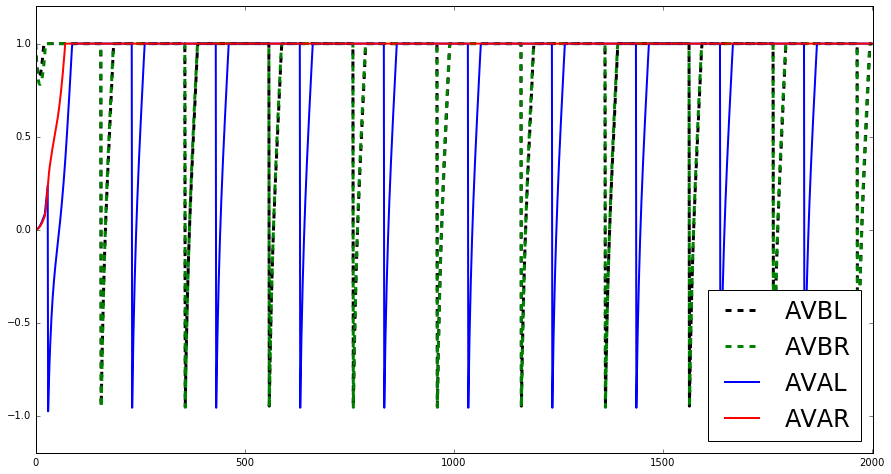

In [69]:
# To makes plotting various plot together easier and cleaner
color = itertools.cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))

# To give the figure nice proportions, python's default is a bit small
plt.figure(figsize=(15, 8))

# y-axis limits
plt.ylim(-1.2, 1.2)    

# x-axis limits
plt.xlim(0, len(logDF)) 

# what we actually want to plot
plt.plot(logDF['AVBL'],'--', color='black', lw=3, label="AVBL")
plt.plot(logDF['AVBR'],'--', color='green', lw=3, label="AVBR")
plt.plot(logDF['AVAL'],'-', color='blue', lw=2, label="AVAL")
plt.plot(logDF['AVAR'],'-', color='red', lw=2, label="AVAR")
# plt.plot(logDF['AVDL'],'-', color='k', lw=1)
# plt.plot(logDF['AVDR'],'-', color='y', lw=1)
plt.legend(fontsize=24, loc=4)
plt.savefig("AVBvsAVA.png")


### Example 2: Plotting Several Motor Neurons vs. AVBL

This is the only line of code we need to change, depending on the neurons we wish to plot:

In [70]:
neuronsToPlot = logDF.loc[:,'AIBL':'AVM'].columns

In [71]:
neuronsToPlot.append

<bound method Index.append of Index([u'AIBL', u'AIBR', u'ALML', u'ALMR', u'AVAL', u'AVAR', u'AVBL', u'AVBR',
       u'AVDL', u'AVDR', u'AVM'],
      dtype='object')>

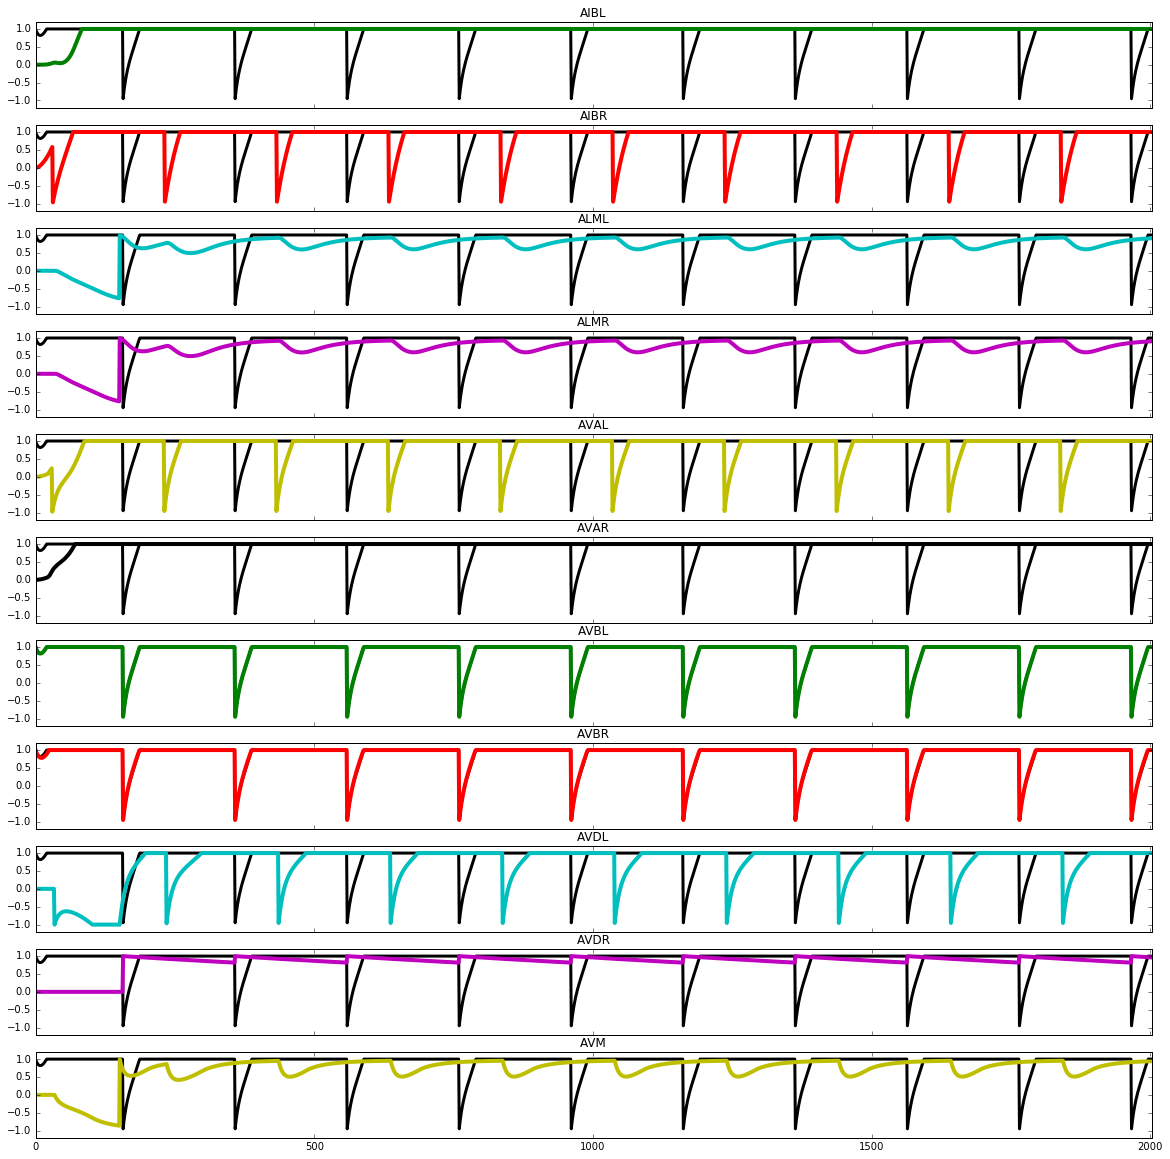

In [72]:
# To makes plotting various plot together easier and cleaner
color = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k'))

nrows = len(neuronsToPlot)
fig, axes = plt.subplots(nrows, 1, sharex=True, sharey=True, figsize=(20,20))

for i, row in enumerate(axes):
    row.set_ylim(-1.2, 1.2)
    row.set_xlim(0, len(logDF))
    
    row.set_title(neuronsToPlot[i])
    row.plot(logDF['AVBL'],'-', color='black', lw=3)
    row.plot(logDF[neuronsToPlot[i]], color=color.next(), lw=4)

This is a code segment to display VB1-7 vs. DB1-7:

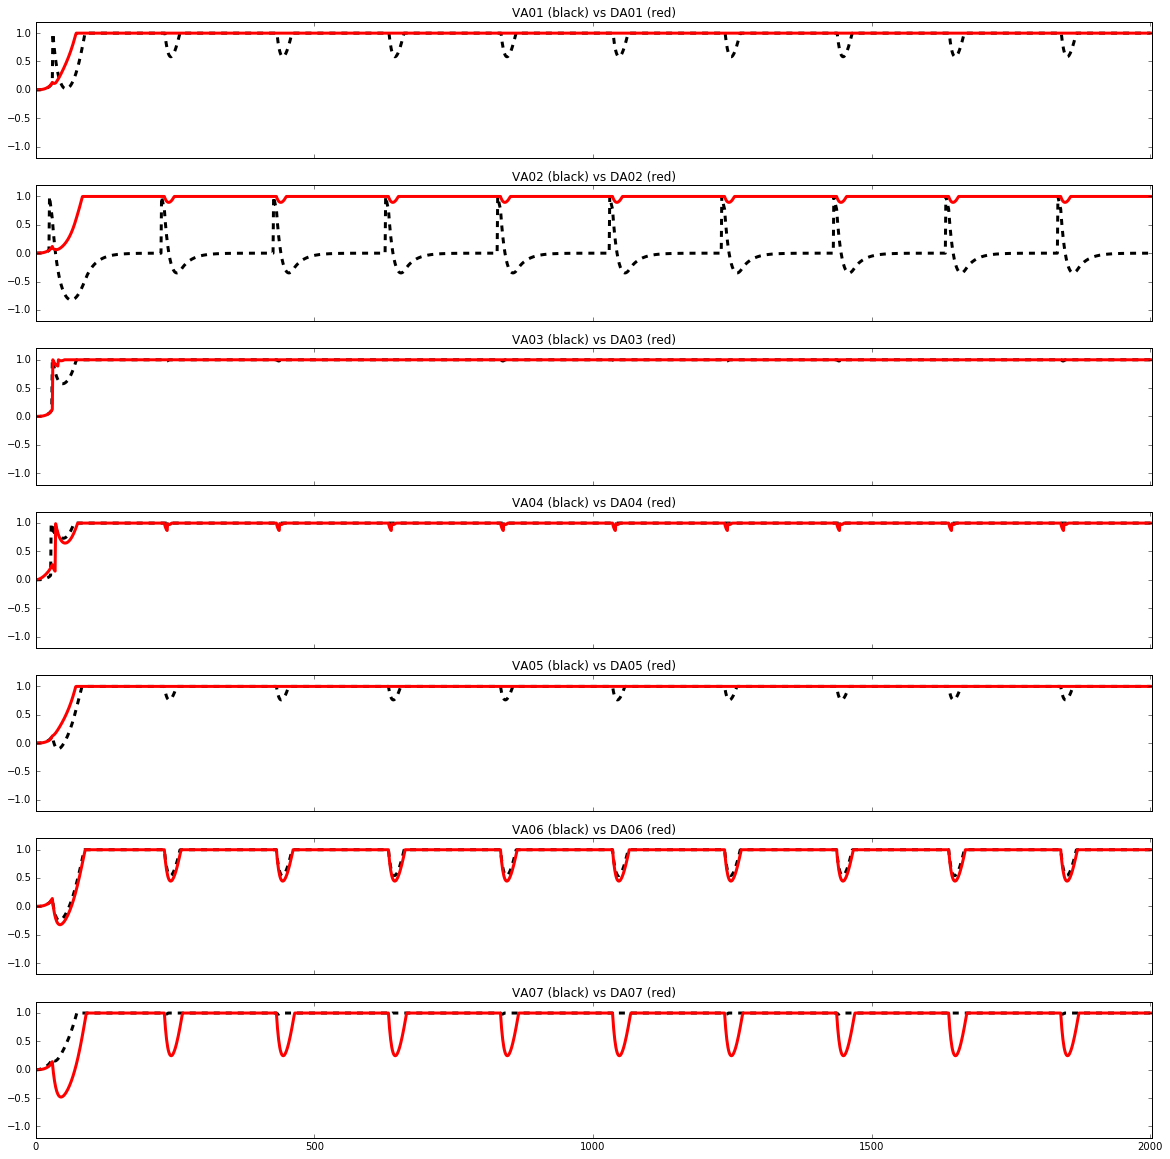

In [73]:
# To makes plotting various plot together easier and cleaner
color = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k'))

nrows = 7
fig, axes = plt.subplots(nrows, 1, sharex=True, sharey=True, figsize=(20,20))

for i, row in enumerate(axes):
    row.set_ylim(-1.2, 1.2)
    row.set_xlim(0, len(logDF))
    
    row.set_title('VA0'+str(i+1)+' (black) vs DA0'+str(i+1) + " (red)")
    row.plot(logDF['VA0'+str(i+1)], '--',color='black', lw=3)
    row.plot(logDF['DA0'+str(i+1)], '-', color='red', lw=3)

### Example 3: Plotting VBs vs. DBs according to body segment

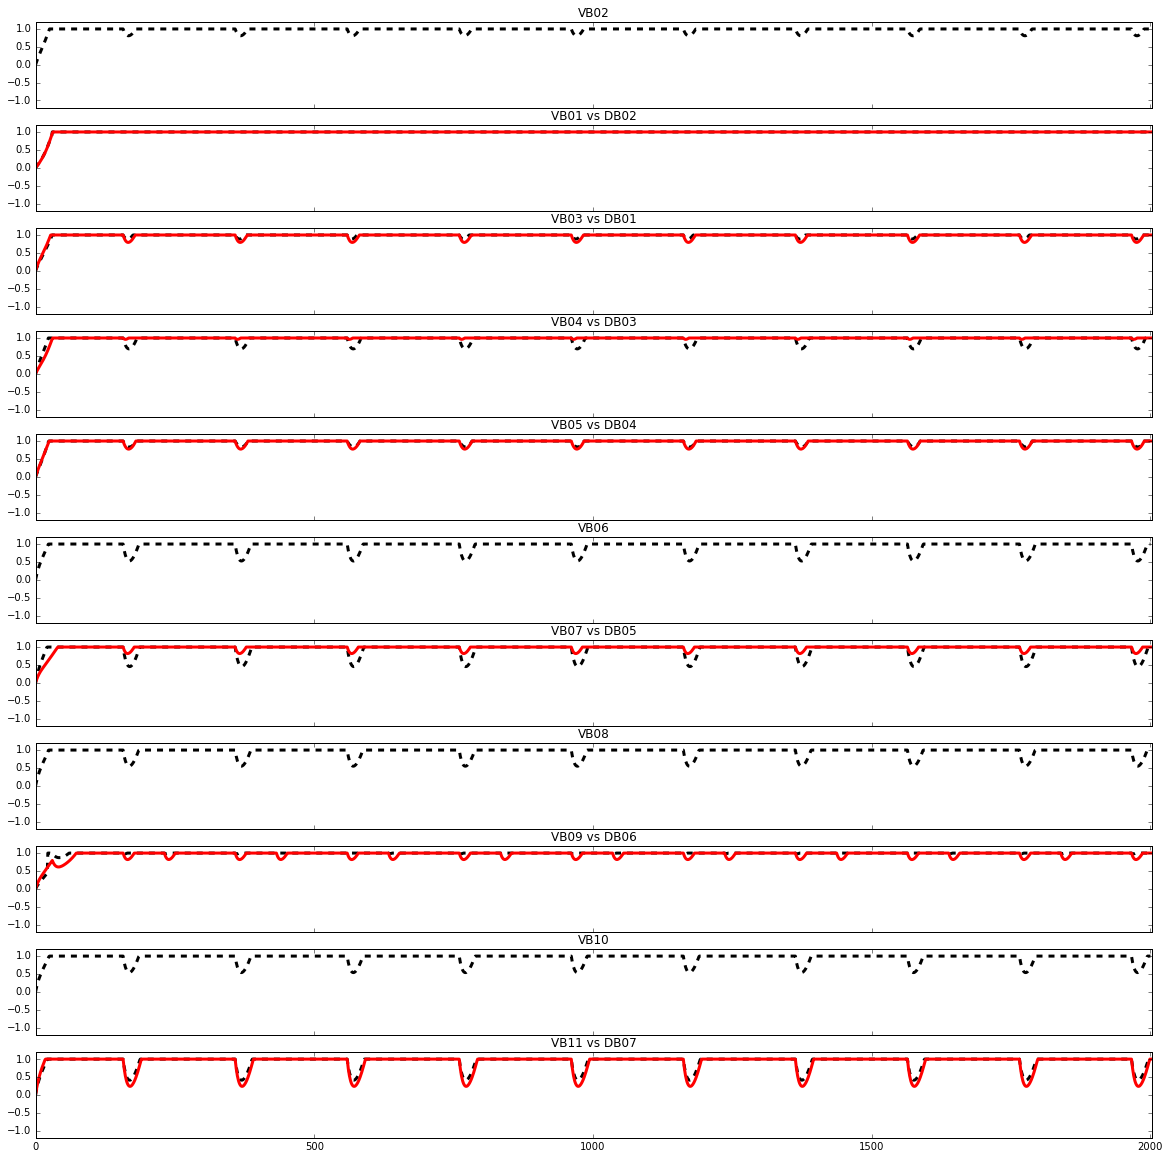

In [74]:
# To makes plotting various plot together easier and cleaner
color = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k'))

nrows = 11
fig, axes = plt.subplots(nrows, 1, sharex=True, sharey=True, figsize=(20,20))

for row in axes:
    row.set_ylim(-1.2, 1.2)
    row.set_xlim(0, len(logDF))

axes[0].set_title('VB02')
axes[0].plot(logDF['VB02'], '--',color='black', lw=3)

axes[1].set_title('VB01 vs DB02')
axes[1].plot(logDF['VB01'], '--',color='black', lw=3)
axes[1].plot(logDF['DB02'], '-', color='red', lw=3)    

axes[2].set_title('VB03 vs DB01')
axes[2].plot(logDF['VB03'], '--',color='black', lw=3)
axes[2].plot(logDF['DB01'], '-', color='red', lw=3)    

axes[3].set_title('VB04 vs DB03')
axes[3].plot(logDF['VB04'], '--',color='black', lw=3)
axes[3].plot(logDF['DB03'], '-', color='red', lw=3)    

axes[4].set_title('VB05 vs DB04')
axes[4].plot(logDF['VB05'], '--',color='black', lw=3)
axes[4].plot(logDF['DB04'], '-', color='red', lw=3) 

axes[5].set_title('VB06')
axes[5].plot(logDF['VB06'], '--',color='black', lw=3)

axes[6].set_title('VB07 vs DB05')
axes[6].plot(logDF['VB07'], '--',color='black', lw=3)
axes[6].plot(logDF['DB05'], '-', color='red', lw=3) 

axes[7].set_title('VB08')
axes[7].plot(logDF['VB08'], '--',color='black', lw=3)

axes[8].set_title('VB09 vs DB06')
axes[8].plot(logDF['VB09'], '--',color='black', lw=3)
axes[8].plot(logDF['DB06'], '-', color='red', lw=3) 

axes[9].set_title('VB10')
axes[9].plot(logDF['VB10'], '--',color='black', lw=3)

axes[10].set_title('VB11 vs DB07')
axes[10].plot(logDF['VB11'], '--',color='black', lw=3)
axes[10].plot(logDF['DB07'], '-', color='red', lw=3) 

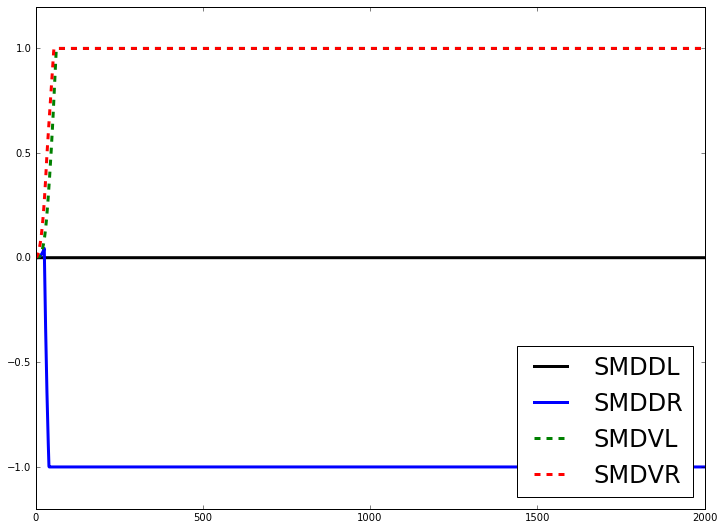

In [75]:
# To give the figure nice proportions, python's default is a bit small
plt.figure(figsize=(12, 9))

# y-axis limits
plt.ylim(-1.2, 1.2)    

# x-axis limits
plt.xlim(0, len(logDF)) 

# what we actually want to plot
plt.plot(logDF['SMDDL'],'-', color='black', lw=3, label="SMDDL")
plt.plot(logDF['SMDDR'],'-', color='blue', lw=3, label="SMDDR")
plt.plot(logDF['SMDVL'],'--', color='green', lw=3, label="SMDVL")
plt.plot(logDF['SMDVR'],'--', color='red', lw=3, label="SMDVR")
plt.legend(fontsize=24, loc=4)

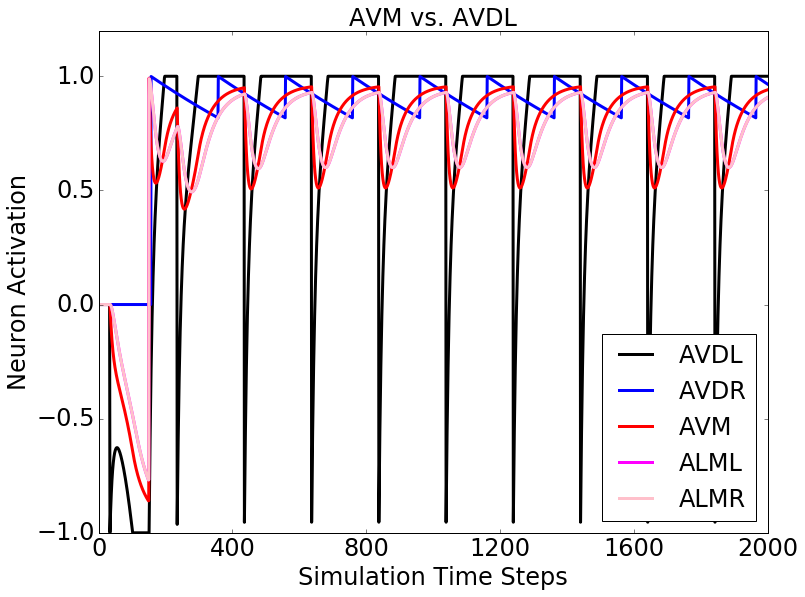

In [76]:
# To give the figure nice proportions, python's default is a bit small
plt.figure(figsize=(12, 9))

# y-axis limits
plt.ylim(0, 1.2)    

# x-axis limits
plt.xlim(0, len(logDF)) 

# what we actually want to plot
plt.title("AVM vs. AVDL", fontsize = 24)
plt.xlabel("Simulation Time Steps", fontsize = 24)
plt.xticks([0,400,800,1200,1600,2000], fontsize = 24)
plt.ylabel("Neuron Activation", fontsize = 24)
plt.yticks([-1, -0.5, 0,0.5,1], fontsize = 24)
plt.plot(logDF['AVDL'],'-', color='black', lw=3, label="AVDL")
plt.plot(logDF['AVDR'],'-', color='blue', lw=3, label="AVDR")
plt.plot(logDF['AVM'],'-', color='red', lw=3, label="AVM")
plt.plot(logDF['ALML'],'-', color='magenta', lw=3, label="ALML")
plt.plot(logDF['ALMR'],'-', color='pink', lw=3, label="ALMR")
plt.legend(fontsize=24, loc=4)
plt.savefig("AVDUP")